In [2]:
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
#
import pygraphviz as pgv
import networkx as nx
import json
import re
import warnings
warnings.filterwarnings('ignore')
# 
import socket

**Network Graphing with networkx, pygraphviz**

originally from
https://www.analyticsvidhya.com/blog/2018/04/introduction-to-graph-theory-network-analysis-python-codes/

In [3]:
# Creating a Graph 
G = nx.Graph() # Right now G is empty

# Add a node
G.add_node(1) 
G.add_nodes_from([2,3]) # You can also add a list of nodes by passing a list argument

# Add edges 
G.add_edge(1,2)

e = (2,3)
G.add_edge(*e) # * unpacks the tuple
G.add_edges_from([(1,2), (1,3)]) # Just like nodes we can add edges from a list

In [4]:
G.nodes()

NodeView((1, 2, 3))

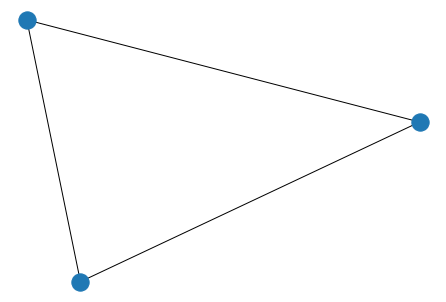

In [5]:
nx.draw(G)

In [6]:
d={'1': {'2': None}, '2': {'1': None, '3': None}, '3': {'1': None}}
A = pgv.AGraph(data=d)
print(A) # This is the 'string' or simple representation of the Graph

strict graph "" {
	1 -- 2;
	2 -- 3;
	3 -- 1;
}



In [7]:
# Let us create another Graph where we can individually control the colour of each node
B = pgv.AGraph()

# Setting node attributes that are common for all nodes 
B.node_attr['style']='filled'
B.node_attr['shape']='circle'
B.node_attr['fixedsize']='true'
B.node_attr['fontcolor']='#FFFFFF'

# Creating and setting node attributes that vary for each node (using a for loop)
for i in range(16):
 B.add_edge(0,i)
 n=B.get_node(i)
 n.attr['fillcolor']="#%2x0000"%(i*16)
 n.attr['height']="%s"%(i/16.0+0.5)
 n.attr['width']="%s"%(i/16.0+0.5)
B.draw('star.png',prog="circo") # This creates a .png file in the local directory. Displayed below.

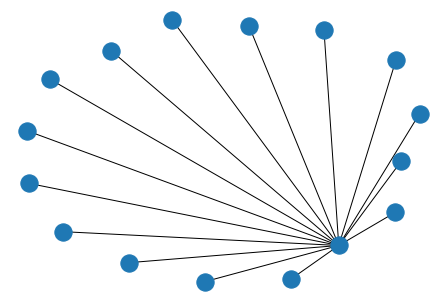

In [8]:
# weird how nx.draw(B) and B.draw do different things
nx.draw(B)

In [9]:
from IPython.display import Image

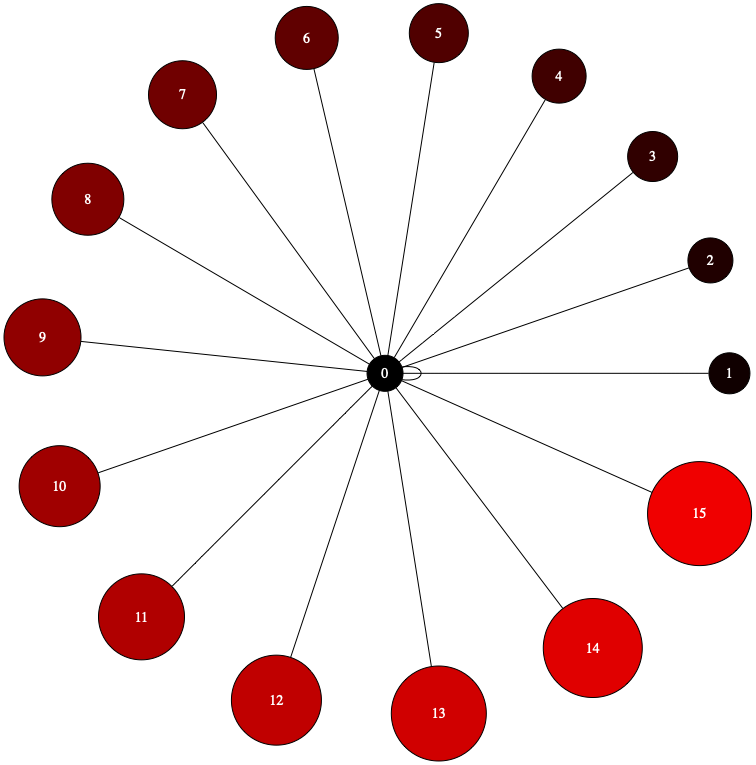

In [10]:
Image('star.png', width=650)
#Image('images/network.PNG')

**Analyzing sample airlines data**

- We notice that origin and destination look like good choices for Nodes. Everything can then be imagined as either node or edge attributes. A single edge can be thought of as a journey. And such a journey will have various times, a flight number, an airplane tail number etc associated with it
- We notice that the year, month, day and time information is spread over many columns. We want to create one datetime column containing all of this information. We also need to keep scheduled and actual time of arrival and departure separate. So we should finally have 4 datetime columns (Scheduled and actual times of arrival and departure)
- Additionally, the time columns are not in a proper format. 4:30 pm is represented as 1630 instead of 16:30. There is no delimiter to split that column. One approach is to use pandas string methods and regular expressions
- We should also note that sched_dep_time and sched_arr_time are int64 dtype and dep_time and arr_time are float64 dtype
- An additional complication is NaN values


In [11]:
data = pd.read_csv('data/Airlines.csv')

In [12]:
data.shape

(100, 16)

In [13]:
data.dtypes

year                int64
month               int64
day                 int64
dep_time          float64
sched_dep_time      int64
dep_delay         float64
arr_time          float64
sched_arr_time      int64
arr_delay         float64
carrier            object
flight              int64
tailnum            object
origin             object
dest               object
air_time          float64
distance            int64
dtype: object

In [14]:
data.head(3)

,year,month,day,dep_time,sched_dep_time,dep_delay,arr_time,sched_arr_time,arr_delay,carrier,flight,tailnum,origin,dest,air_time,distance
0,2013,2,26,1807.0,1630,97.0,1956.0,1837,79.0,EV,4411,N13566,EWR,MEM,144.0,946
1,2013,8,17,1459.0,1445,14.0,1801.0,1747,14.0,B6,1171,N661JB,LGA,FLL,147.0,1076
2,2013,2,13,1812.0,1815,-3.0,2055.0,2125,-30.0,AS,7,N403AS,EWR,SEA,315.0,2402


Create useful date features

In [15]:
# converting sched_dep_time to 'std' - Scheduled time of departure
data['std'] = data.sched_dep_time.astype(str).str.replace('(\d{2}$)', '') + ':' + data.sched_dep_time.astype(str).str.extract('(\d{2}$)', expand=False) + ':00'

In [16]:
# converting sched_arr_time to 'sta' - Scheduled time of arrival
data['sta'] = data.sched_arr_time.astype(str).str.replace('(\d{2}$)', '') + ':' + data.sched_arr_time.astype(str).str.extract('(\d{2}$)', expand=False) + ':00'

In [17]:
# converting dep_time to 'atd' - Actual time of departure
data['atd'] = data.dep_time.fillna(0).astype(np.int64).astype(str).str.replace('(\d{2}$)', '') + ':' + data.dep_time.fillna(0).astype(np.int64).astype(str).str.extract('(\d{2}$)', expand=False) + ':00'

In [18]:
# converting arr_time to 'ata' - Actual time of arrival
data['ata'] = data.arr_time.fillna(0).astype(np.int64).astype(str).str.replace('(\d{2}$)', '') + ':' + data.arr_time.fillna(0).astype(np.int64).astype(str).str.extract('(\d{2}$)', expand=False) + ':00'

Make a single date feature

In [19]:
data['date'] = pd.to_datetime(data[['year', 'month', 'day']])

In [20]:
# finally we drop the columns we don't need
data = data.drop(columns = ['year', 'month', 'day'])

Ingest the dataset directly into pandas from nx

In [21]:
FG = nx.from_pandas_edgelist(data, source='origin', target='dest', edge_attr=True,)

In [22]:
FG.nodes()

NodeView(('EWR', 'MEM', 'LGA', 'FLL', 'SEA', 'JFK', 'DEN', 'ORD', 'MIA', 'PBI', 'MCO', 'CMH', 'MSP', 'IAD', 'CLT', 'TPA', 'DCA', 'SJU', 'ATL', 'BHM', 'SRQ', 'MSY', 'DTW', 'LAX', 'JAX', 'RDU', 'MDW', 'DFW', 'IAH', 'SFO', 'STL', 'CVG', 'IND', 'RSW', 'BOS', 'CLE'))

In [23]:
FG.edges()

EdgeView([('EWR', 'MEM'), ('EWR', 'SEA'), ('EWR', 'MIA'), ('EWR', 'ORD'), ('EWR', 'MSP'), ('EWR', 'TPA'), ('EWR', 'MSY'), ('EWR', 'DFW'), ('EWR', 'IAH'), ('EWR', 'SFO'), ('EWR', 'CVG'), ('EWR', 'IND'), ('EWR', 'RDU'), ('EWR', 'IAD'), ('EWR', 'RSW'), ('EWR', 'BOS'), ('EWR', 'PBI'), ('EWR', 'LAX'), ('EWR', 'MCO'), ('EWR', 'SJU'), ('LGA', 'FLL'), ('LGA', 'ORD'), ('LGA', 'PBI'), ('LGA', 'CMH'), ('LGA', 'IAD'), ('LGA', 'CLT'), ('LGA', 'MIA'), ('LGA', 'DCA'), ('LGA', 'BHM'), ('LGA', 'RDU'), ('LGA', 'ATL'), ('LGA', 'TPA'), ('LGA', 'MDW'), ('LGA', 'DEN'), ('LGA', 'MSP'), ('LGA', 'DTW'), ('LGA', 'STL'), ('LGA', 'MCO'), ('LGA', 'CVG'), ('LGA', 'IAH'), ('FLL', 'JFK'), ('SEA', 'JFK'), ('JFK', 'DEN'), ('JFK', 'MCO'), ('JFK', 'TPA'), ('JFK', 'SJU'), ('JFK', 'ATL'), ('JFK', 'SRQ'), ('JFK', 'DCA'), ('JFK', 'DTW'), ('JFK', 'LAX'), ('JFK', 'JAX'), ('JFK', 'CLT'), ('JFK', 'PBI'), ('JFK', 'CLE'), ('JFK', 'IAD'), ('JFK', 'BOS')])

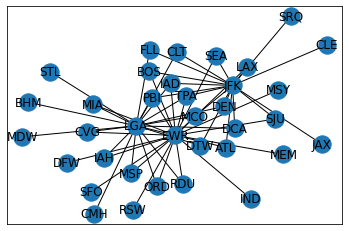

In [24]:
nx.draw_networkx(FG, with_labels=True) # Quick view of the Graph. As expected we see 3 very busy airports

In [25]:
nx.algorithms.degree_centrality(FG) # Notice the 3 airports from which all of our 100 rows of data originates
nx.density(FG) # Average edge density of the Graphs

0.09047619047619047

In [26]:
nx.average_shortest_path_length(FG) # Average shortest path length for ALL paths in the Graph

2.36984126984127

In [27]:
nx.average_degree_connectivity(FG) # For a node of degree k - What is the average of its neighbours' degree?

{20: 1.95, 1: 19.307692307692307, 2: 19.0625, 17: 2.0588235294117645, 3: 19.0}

As is obvious from looking at the Graph visualization (way above) – There are multiple paths from some airports to others. Let us say we want to calculate the shortest possible route between 2 such airports. Right off the bat we can think of a couple of ways of doing it

    There is the shortest path by distance
    There is the shortest path by flight time

What we can do is to calculate the shortest path algorithm by weighing the paths with either the distance or airtime. Please note that this is an approximate solution – The actual problem to solve is to calculate the shortest path factoring in the availability of a flight when you reach your transfer airport + wait time for the transfer. This is a more complete approach and this is how humans normally plan their travel. For the purposes of this article we will just assume that is flight is readily available when you reach an airport and calculate the shortest path using the airtime as the weight

In [28]:
# Let us take the example of JAX and DFW airports:
# Let us find all the paths available
for path in nx.all_simple_paths(FG, source='JAX', target='DFW'):
 print(path)

['JAX', 'JFK', 'DEN', 'LGA', 'ORD', 'EWR', 'DFW']
['JAX', 'JFK', 'DEN', 'LGA', 'PBI', 'EWR', 'DFW']
['JAX', 'JFK', 'DEN', 'LGA', 'IAD', 'EWR', 'DFW']
['JAX', 'JFK', 'DEN', 'LGA', 'MIA', 'EWR', 'DFW']
['JAX', 'JFK', 'DEN', 'LGA', 'RDU', 'EWR', 'DFW']
['JAX', 'JFK', 'DEN', 'LGA', 'TPA', 'EWR', 'DFW']
['JAX', 'JFK', 'DEN', 'LGA', 'MSP', 'EWR', 'DFW']
['JAX', 'JFK', 'DEN', 'LGA', 'MCO', 'EWR', 'DFW']
['JAX', 'JFK', 'DEN', 'LGA', 'CVG', 'EWR', 'DFW']
['JAX', 'JFK', 'DEN', 'LGA', 'IAH', 'EWR', 'DFW']
['JAX', 'JFK', 'SEA', 'EWR', 'DFW']
['JAX', 'JFK', 'MCO', 'LGA', 'ORD', 'EWR', 'DFW']
['JAX', 'JFK', 'MCO', 'LGA', 'PBI', 'EWR', 'DFW']
['JAX', 'JFK', 'MCO', 'LGA', 'IAD', 'EWR', 'DFW']
['JAX', 'JFK', 'MCO', 'LGA', 'MIA', 'EWR', 'DFW']
['JAX', 'JFK', 'MCO', 'LGA', 'RDU', 'EWR', 'DFW']
['JAX', 'JFK', 'MCO', 'LGA', 'TPA', 'EWR', 'DFW']
['JAX', 'JFK', 'MCO', 'LGA', 'MSP', 'EWR', 'DFW']
['JAX', 'JFK', 'MCO', 'LGA', 'CVG', 'EWR', 'DFW']
['JAX', 'JFK', 'MCO', 'LGA', 'IAH', 'EWR', 'DFW']
['JAX', 'JFK',

In [29]:
# Let us find the dijkstra path from JAX to DFW.
# You can read more in-depth on how dijkstra works from this resource - https://courses.csail.mit.edu/6.006/fall11/lectures/lecture16.pdf
dijpath = nx.dijkstra_path(FG, source='JAX', target='DFW')
dijpath

['JAX', 'JFK', 'SEA', 'EWR', 'DFW']

In [30]:
# Let us try to find the dijkstra path weighted by airtime (approximate case)
shortpath = nx.dijkstra_path(FG, source='JAX', target='DFW', weight='air_time')
shortpath

['JAX', 'JFK', 'BOS', 'EWR', 'DFW']

## Network graphs for IP networks

Originally from. 
http://www.austintaylor.io/d3/python/pandas/2016/02/01/create-d3-chart-python-force-directed/

the notion is to take the methodology and translate it into nx instead of d3

In [31]:
pcap_data = pd.read_csv('data/test10.csv')

In [32]:
pcap_data.head()

,ip.src,ip.dst,ip.proto,udp.dstport,ip.len,frame.time_delta_displayed
0,10.52.3.50,10.52.3.15,6.0,NaN,104.0,0.000000
1,10.52.3.15,10.52.3.50,6.0,NaN,80.0,0.000906
2,10.52.3.50,10.52.3.15,6.0,NaN,52.0,0.002231
3,10.52.3.8,10.52.3.1,17.0,137.0,78.0,1.236884
4,NaN,NaN,NaN,NaN,NaN,0.000533


In [33]:
# subset source and destination only
df = pcap_data[['ip.src','ip.dst']].dropna().copy()

In [34]:
df.head()

,ip.src,ip.dst
0,10.52.3.50,10.52.3.15
1,10.52.3.15,10.52.3.50
2,10.52.3.50,10.52.3.15
3,10.52.3.8,10.52.3.1
8,10.52.3.50,239.255.255.250


In [35]:
df.rename(columns={"ip.src":"source","ip.dst":"target"}, inplace=True)

In [36]:
df.head()

,source,target
0,10.52.3.50,10.52.3.15
1,10.52.3.15,10.52.3.50
2,10.52.3.50,10.52.3.15
3,10.52.3.8,10.52.3.1
8,10.52.3.50,239.255.255.250


In [37]:
df.groupby(["source","target"]).size().head()

source       target     
10.52.3.1    10.52.3.255     12
             10.52.3.8       47
10.52.3.105  224.0.0.22      39
             224.0.0.251    135
10.52.3.15   10.52.3.50      73
dtype: int64

In [38]:
dfgroup = df.groupby(["source","target"]).size().reset_index()

In [39]:
dfgroup.head()

,source,target,0
0,10.52.3.1,10.52.3.255,12
1,10.52.3.1,10.52.3.8,47
2,10.52.3.105,224.0.0.22,39
3,10.52.3.105,224.0.0.251,135
4,10.52.3.15,10.52.3.50,73


In [40]:
dfgroup.rename(columns={0:'count'}, inplace=True)

In [41]:
dfgroup.head()

,source,target,count
0,10.52.3.1,10.52.3.255,12
1,10.52.3.1,10.52.3.8,47
2,10.52.3.105,224.0.0.22,39
3,10.52.3.105,224.0.0.251,135
4,10.52.3.15,10.52.3.50,73


In [42]:
# this will be referred to later
unique_ips = pd.Index(dfgroup['source']
                      .append(dfgroup['target'])
                      .reset_index(drop=True).unique())

In [43]:
unique_ips

Index(['10.52.3.1', '10.52.3.105', '10.52.3.15', '10.52.3.20', '10.52.3.50',
       '10.52.3.7', '10.52.3.8', '10.52.3.9', '131.186.113.70',
       '131.186.161.70', '162.88.193.70', '17.142.169.199', '17.248.130.8',
       '17.253.16.125', '17.253.16.253', '17.253.26.125', '17.253.4.253',
       '17.57.144.180', '17.57.144.181', '172.217.14.202', '172.217.14.227',
       '172.217.14.238', '172.217.3.170', '184.26.80.199', '209.197.193.112',
       '209.197.193.90', '216.146.43.70', '216.146.43.71', '23.204.60.203',
       '23.52.168.63', '23.52.169.148', '3.213.160.221', '64.68.120.47',
       '72.21.91.29', '91.189.94.4', '10.52.3.255', '224.0.0.22',
       '224.0.0.251', '239.255.255.250'],
      dtype='object')

Create subnet group
Note: We use regular expression here to group the various subnets to the third octect. For example, if you have 2 IP addresses (192.168.1.5, 192.168.2.5), they’d both be treated as 2 networks. We’ll use this to group the subnets by color and create our groups.

In [44]:
group_dict = {}
counter = 0
for ip in unique_ips:
    breakout_ip = re.match("^(\d{1,3})\.(\d{1,3})\.(\d{1,3})\.(\d{1,3})$", ip)
    if breakout_ip:
        net_id = '.'.join(breakout_ip.group(1,2,3))
        if net_id not in group_dict:
            counter += 1
            group_dict[net_id] = counter
        else:
            pass

In [45]:
breakout_ip

<re.Match object; span=(0, 15), match='239.255.255.250'>

In [46]:
temp_links_list = list(dfgroup.apply(lambda row: {"source": row['source'], "target": row['target'], "value": row['count']}, axis=1))

In [47]:
temp_links_list[:10]

[{'source': '10.52.3.1', 'target': '10.52.3.255', 'value': 12},
 {'source': '10.52.3.1', 'target': '10.52.3.8', 'value': 47},
 {'source': '10.52.3.105', 'target': '224.0.0.22', 'value': 39},
 {'source': '10.52.3.105', 'target': '224.0.0.251', 'value': 135},
 {'source': '10.52.3.15', 'target': '10.52.3.50', 'value': 73},
 {'source': '10.52.3.15', 'target': '224.0.0.251', 'value': 4},
 {'source': '10.52.3.15', 'target': '91.189.94.4', 'value': 4},
 {'source': '10.52.3.20', 'target': '10.52.3.50', 'value': 63},
 {'source': '10.52.3.20', 'target': '224.0.0.251', 'value': 65},
 {'source': '10.52.3.50', 'target': '10.52.3.15', 'value': 146}]

In [48]:
# Now we need to extract the index location for each unique source and destination (target) pair and append it to our links list.
links_list = []
for link in temp_links_list:
    record = {"value":link['value'], "source":unique_ips.get_loc(link['source']),
     "target": unique_ips.get_loc(link['target'])}
    links_list.append(record)

In [49]:
links_list[:10]

[{'value': 12, 'source': 0, 'target': 35},
 {'value': 47, 'source': 0, 'target': 6},
 {'value': 39, 'source': 1, 'target': 36},
 {'value': 135, 'source': 1, 'target': 37},
 {'value': 73, 'source': 2, 'target': 4},
 {'value': 4, 'source': 2, 'target': 37},
 {'value': 4, 'source': 2, 'target': 34},
 {'value': 63, 'source': 3, 'target': 4},
 {'value': 65, 'source': 3, 'target': 37},
 {'value': 146, 'source': 4, 'target': 2}]

In [50]:
# now create nodes
nodes_list = []

for ip in unique_ips:
    breakout_ip = re.match("^(\d{1,3})\.(\d{1,3})\.(\d{1,3})\.(\d{1,3})$", ip)
    if breakout_ip:
        net_id = '.'.join(breakout_ip.group(1,2,3))
        nodes_list.append({"name":ip, "group": group_dict.get(net_id)})

In [51]:
nodes_list[:10]

[{'name': '10.52.3.1', 'group': 1},
 {'name': '10.52.3.105', 'group': 1},
 {'name': '10.52.3.15', 'group': 1},
 {'name': '10.52.3.20', 'group': 1},
 {'name': '10.52.3.50', 'group': 1},
 {'name': '10.52.3.7', 'group': 1},
 {'name': '10.52.3.8', 'group': 1},
 {'name': '10.52.3.9', 'group': 1},
 {'name': '131.186.113.70', 'group': 2},
 {'name': '131.186.161.70', 'group': 3}]

In [52]:
# now turn the data into json for the d3 example
json_prep = {"nodes":nodes_list, "links":links_list}

json_prep.keys()

dict_keys(['nodes', 'links'])

In [53]:
type(json_prep)

dict

In [54]:
json_dump = json.dumps(json_prep, indent=1, sort_keys=True)
print(json_dump)

{
 "links": [
  {
   "source": 0,
   "target": 35,
   "value": 12
  },
  {
   "source": 0,
   "target": 6,
   "value": 47
  },
  {
   "source": 1,
   "target": 36,
   "value": 39
  },
  {
   "source": 1,
   "target": 37,
   "value": 135
  },
  {
   "source": 2,
   "target": 4,
   "value": 73
  },
  {
   "source": 2,
   "target": 37,
   "value": 4
  },
  {
   "source": 2,
   "target": 34,
   "value": 4
  },
  {
   "source": 3,
   "target": 4,
   "value": 63
  },
  {
   "source": 3,
   "target": 37,
   "value": 65
  },
  {
   "source": 4,
   "target": 2,
   "value": 146
  },
  {
   "source": 4,
   "target": 3,
   "value": 63
  },
  {
   "source": 4,
   "target": 35,
   "value": 16
  },
  {
   "source": 4,
   "target": 6,
   "value": 4505
  },
  {
   "source": 4,
   "target": 37,
   "value": 113
  },
  {
   "source": 4,
   "target": 38,
   "value": 148
  },
  {
   "source": 5,
   "target": 37,
   "value": 3
  },
  {
   "source": 5,
   "target": 38,
   "value": 96
  },
  {
   "source": 6,


In [55]:
filename_out = 'pcap_export.json'
json_out = open(filename_out,'w')
json_out.write(json_dump)
json_out.close()

### Mapping directly from the dataframe

We lose all the group information with this method

In [56]:
# Here we try to apply the nx method

NG = nx.from_pandas_edgelist(dfgroup, source='source', target='target', edge_attr=True,)

In [57]:
NG.nodes()

NodeView(('10.52.3.1', '10.52.3.255', '10.52.3.8', '10.52.3.105', '224.0.0.22', '224.0.0.251', '10.52.3.15', '10.52.3.50', '91.189.94.4', '10.52.3.20', '239.255.255.250', '10.52.3.7', '131.186.113.70', '131.186.161.70', '162.88.193.70', '17.142.169.199', '17.248.130.8', '17.253.16.125', '17.253.16.253', '17.253.26.125', '17.253.4.253', '17.57.144.180', '172.217.14.202', '172.217.14.227', '172.217.14.238', '172.217.3.170', '184.26.80.199', '209.197.193.112', '209.197.193.90', '216.146.43.70', '216.146.43.71', '23.204.60.203', '23.52.168.63', '23.52.169.148', '3.213.160.221', '64.68.120.47', '72.21.91.29', '10.52.3.9', '17.57.144.181'))

In [58]:
NG.edges()

EdgeView([('10.52.3.1', '10.52.3.255'), ('10.52.3.1', '10.52.3.8'), ('10.52.3.255', '10.52.3.50'), ('10.52.3.255', '10.52.3.8'), ('10.52.3.8', '10.52.3.50'), ('10.52.3.8', '10.52.3.105'), ('10.52.3.8', '131.186.113.70'), ('10.52.3.8', '131.186.161.70'), ('10.52.3.8', '162.88.193.70'), ('10.52.3.8', '17.142.169.199'), ('10.52.3.8', '17.248.130.8'), ('10.52.3.8', '17.253.16.125'), ('10.52.3.8', '17.253.16.253'), ('10.52.3.8', '17.253.26.125'), ('10.52.3.8', '17.253.4.253'), ('10.52.3.8', '17.57.144.180'), ('10.52.3.8', '172.217.14.202'), ('10.52.3.8', '172.217.14.227'), ('10.52.3.8', '172.217.14.238'), ('10.52.3.8', '172.217.3.170'), ('10.52.3.8', '184.26.80.199'), ('10.52.3.8', '209.197.193.112'), ('10.52.3.8', '209.197.193.90'), ('10.52.3.8', '216.146.43.70'), ('10.52.3.8', '216.146.43.71'), ('10.52.3.8', '224.0.0.251'), ('10.52.3.8', '23.204.60.203'), ('10.52.3.8', '23.52.168.63'), ('10.52.3.8', '23.52.169.148'), ('10.52.3.8', '239.255.255.250'), ('10.52.3.8', '3.213.160.221'), ('10.5

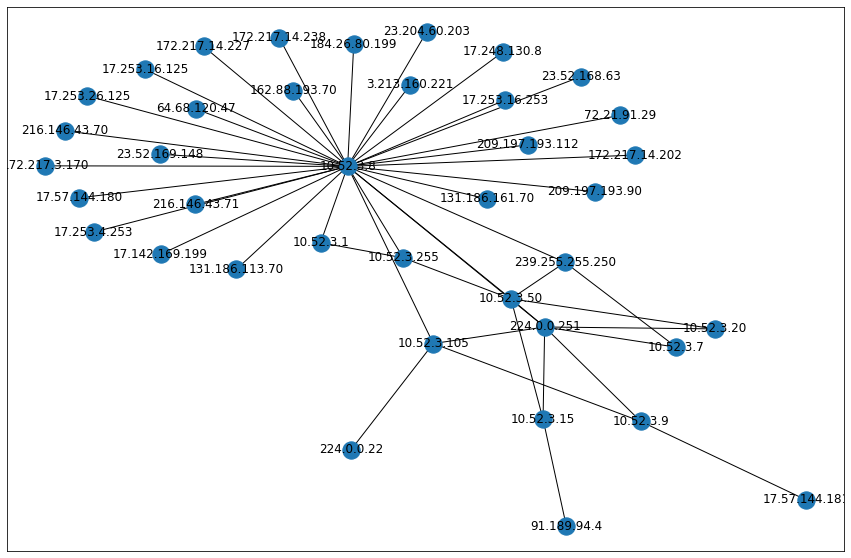

In [59]:
plt.figure(figsize=(15,10))
nx.draw_networkx(NG, with_labels=True)

In [60]:
nx.algorithms.degree_centrality(NG)

{'10.52.3.1': 0.05263157894736842,
 '10.52.3.255': 0.07894736842105263,
 '10.52.3.8': 0.8157894736842105,
 '10.52.3.105': 0.10526315789473684,
 '224.0.0.22': 0.02631578947368421,
 '224.0.0.251': 0.18421052631578946,
 '10.52.3.15': 0.07894736842105263,
 '10.52.3.50': 0.15789473684210525,
 '91.189.94.4': 0.02631578947368421,
 '10.52.3.20': 0.05263157894736842,
 '239.255.255.250': 0.07894736842105263,
 '10.52.3.7': 0.05263157894736842,
 '131.186.113.70': 0.02631578947368421,
 '131.186.161.70': 0.02631578947368421,
 '162.88.193.70': 0.02631578947368421,
 '17.142.169.199': 0.02631578947368421,
 '17.248.130.8': 0.02631578947368421,
 '17.253.16.125': 0.02631578947368421,
 '17.253.16.253': 0.02631578947368421,
 '17.253.26.125': 0.02631578947368421,
 '17.253.4.253': 0.02631578947368421,
 '17.57.144.180': 0.02631578947368421,
 '172.217.14.202': 0.02631578947368421,
 '172.217.14.227': 0.02631578947368421,
 '172.217.14.238': 0.02631578947368421,
 '172.217.3.170': 0.02631578947368421,
 '184.26.80.1

In [61]:
nx.density(NG)

0.06342780026990553

In [62]:
nx.average_shortest_path_length(NG) 

2.292847503373819

In [63]:
nx.average_degree_connectivity(NG) 

{2: 9.5,
 3: 8.666666666666666,
 31: 1.6129032258064515,
 4: 10.5,
 1: 28.035714285714285,
 7: 7.285714285714286,
 6: 8.166666666666666}

In [66]:
nx.dijkstra_path(NG, source='10.52.3.50', target='209.197.193.90')

['10.52.3.50', '10.52.3.8', '209.197.193.90']

### can we add colors to nodes with higher counts?


In [67]:
sorted(json_prep.items())

[('links',
  [{'value': 12, 'source': 0, 'target': 35},
   {'value': 47, 'source': 0, 'target': 6},
   {'value': 39, 'source': 1, 'target': 36},
   {'value': 135, 'source': 1, 'target': 37},
   {'value': 73, 'source': 2, 'target': 4},
   {'value': 4, 'source': 2, 'target': 37},
   {'value': 4, 'source': 2, 'target': 34},
   {'value': 63, 'source': 3, 'target': 4},
   {'value': 65, 'source': 3, 'target': 37},
   {'value': 146, 'source': 4, 'target': 2},
   {'value': 63, 'source': 4, 'target': 3},
   {'value': 16, 'source': 4, 'target': 35},
   {'value': 4505, 'source': 4, 'target': 6},
   {'value': 113, 'source': 4, 'target': 37},
   {'value': 148, 'source': 4, 'target': 38},
   {'value': 3, 'source': 5, 'target': 37},
   {'value': 96, 'source': 5, 'target': 38},
   {'value': 61, 'source': 6, 'target': 0},
   {'value': 36, 'source': 6, 'target': 1},
   {'value': 16, 'source': 6, 'target': 35},
   {'value': 4073, 'source': 6, 'target': 4},
   {'value': 12, 'source': 6, 'target': 8},
   {

In [68]:
dfgroup.head()

,source,target,count
0,10.52.3.1,10.52.3.255,12
1,10.52.3.1,10.52.3.8,47
2,10.52.3.105,224.0.0.22,39
3,10.52.3.105,224.0.0.251,135
4,10.52.3.15,10.52.3.50,73


In [69]:
dfgroup.sort_values('count', ascending=False)[:10]

,source,target,count
12,10.52.3.50,10.52.3.8,4505
20,10.52.3.8,10.52.3.50,4073
37,10.52.3.8,209.197.193.90,446
68,209.197.193.90,10.52.3.8,319
14,10.52.3.50,239.255.255.250,148
9,10.52.3.50,10.52.3.15,146
44,10.52.3.8,239.255.255.250,144
3,10.52.3.105,224.0.0.251,135
25,10.52.3.8,17.248.130.8,122
13,10.52.3.50,224.0.0.251,113


In [70]:
dfgroup.dtypes

source    object
target    object
count      int64
dtype: object

**Side trip - can we get hostnames?**

In [71]:
#socket.gethostbyaddr('203.208.60.1')
for i, v in dfgroup.head(2).iterrows():
    print(v['source'], v['source'])

10.52.3.1 10.52.3.1
10.52.3.1 10.52.3.1


In [72]:
socket.gethostbyaddr('23.204.60.203')

('a23-204-60-203.deploy.static.akamaitechnologies.com',
 ['203.60.204.23.in-addr.arpa'],
 ['23.204.60.203'])

In [73]:
socket.gethostbyaddr('17.253.26.125')[0]

'uslax1-ntp-001.aaplimg.com'

In [74]:
socket.gethostbyaddr('23.204.60.203')[1][0]

'203.60.204.23.in-addr.arpa'

In [86]:
# socket.gethostbyaddr('17.253.26.125')
# # sourcename=''
# # targetname=''
# for i, v in dfgroup.head(20).iterrows():
#     print(v)
#     try:
#         sourcename, targetname = socket.gethostbyaddr(v['source']),socket.gethostbyaddr(v['target']) 
#     except Exception as e: 
#         print('Error at', e)
#     if sourcename is None:
#         sourcename = socket.gethostbyaddr(v['source'])
#     if targetname is None:
#         targetname = socket.gethostbyaddr(v['target'])
#     print(sourcename)
#     if sourcename:
#         print("Source: ", sourcename[0], "Target: ", targetname[0])

In [87]:
df['source'][1]

'10.52.3.15'

In [88]:
socket.gethostbyaddr(df['source'][1])

herror: [Errno 1] Unknown host

In [ ]:
def hostname(ip):
    "attempts to resolve a hostname"
    mcast = ['224.0.0.251', '224.0.0.1','224.0.0.2','224.0.0.22']
    if ip in mcast:
        return 'multicast'
    elif ip == '192.168.1.255':
        return 'broadcast'
    elif ip == '239.255.255.250':
        return 'SSDP'
    else:
        try:
            if socket.gethostbyaddr(ip):
                return socket.gethostbyaddr(ip)[0]
        except:
            return ip

In [ ]:
hostname(df['source'][1])

In [ ]:
hostname(df['source'][0])

In [ ]:
df['tar'][1]

In [ ]:
dfgroup.drop(columns=['sourcename','targetname'], inplace=True)

In [ ]:
dfgroup['sourcename'], dfgroup['targetname'] = dfgroup['source'].apply(hostname), dfgroup['target'].apply(hostname)

In [ ]:
dfgroup

Ok - added!

In [ ]:
ng2 = nx.from_pandas_edgelist(dfgroup, source='sourcename', target='targetname', edge_attr=True,)

In [ ]:
plt.figure(figsize=(20,15))
nx.draw_networkx(ng2, with_labels=True)

In [ ]:
import seaborn as sns


In [ ]:
plt.figure(figsize=(12,5))
plt.xticks(rotation=45, ha='right',horizontalalignment='right')
plt.tight_layout(pad=0)
sns.countplot('sourcename',data=dfgroup,palette='summer')

In [ ]:
plt.figure(figsize=(12,5))
plt.xticks(rotation=45, ha='right',horizontalalignment='right')
plt.tight_layout(pad=0)
sns.countplot('targetname',data=dfgroup,palette='summer')

### networkx with the extracted json

Trying to make the extracted json work with networkx

In [ ]:
NG.nodes

In [89]:
from itertools import count

In [90]:
g = nx.Graph()

In [91]:
groups = set(nx.get_node_attributes(g,'group').values())

In [92]:
json_prep.keys()

dict_keys(['nodes', 'links'])

In [93]:
json_prep['nodes'][0]

{'name': '10.52.3.1', 'group': 1}

In [94]:
json_prep['links'][1].items()

dict_items([('value', 47), ('source', 0), ('target', 6)])

In [95]:
json_prep['links'][0]['value']

12

In [96]:
# g = nx.Graph(json_prep['nodes']) #doesn't take all in
g = nx.Graph()

In [97]:
for x in range(0,len(json_prep['nodes'])):
    g.add_node(json_prep['nodes'][x]['name'],group=json_prep['nodes'][x]['group'])

In [98]:
for x in range(0,len(json_prep['links'])):
    g.add_edge(json_prep['links'][x]['source'], json_prep['links'][x]['target'],value=json_prep['links'][x]['value'])

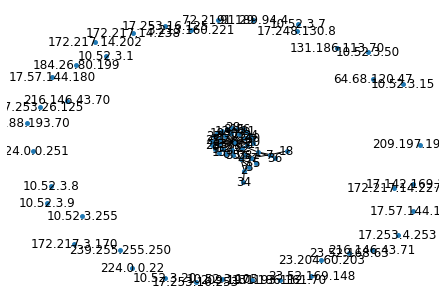

In [99]:
# not fantastic. Can't read groups, no directed edge lines
nx.draw(g, with_labels=True, node_size=15)

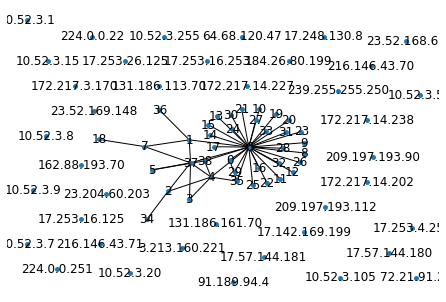

In [100]:
#fix the scale with pydot - still not much better. Edgelines, but no sense of group to IP
nx.draw(g, pos = nx.nx_pydot.graphviz_layout(g), with_labels=True, node_size=15)

In [101]:
g.nodes(data=True)

NodeDataView({'10.52.3.1': {'group': 1}, '10.52.3.105': {'group': 1}, '10.52.3.15': {'group': 1}, '10.52.3.20': {'group': 1}, '10.52.3.50': {'group': 1}, '10.52.3.7': {'group': 1}, '10.52.3.8': {'group': 1}, '10.52.3.9': {'group': 1}, '131.186.113.70': {'group': 2}, '131.186.161.70': {'group': 3}, '162.88.193.70': {'group': 4}, '17.142.169.199': {'group': 5}, '17.248.130.8': {'group': 6}, '17.253.16.125': {'group': 7}, '17.253.16.253': {'group': 7}, '17.253.26.125': {'group': 8}, '17.253.4.253': {'group': 9}, '17.57.144.180': {'group': 10}, '17.57.144.181': {'group': 10}, '172.217.14.202': {'group': 11}, '172.217.14.227': {'group': 11}, '172.217.14.238': {'group': 11}, '172.217.3.170': {'group': 12}, '184.26.80.199': {'group': 13}, '209.197.193.112': {'group': 14}, '209.197.193.90': {'group': 14}, '216.146.43.70': {'group': 15}, '216.146.43.71': {'group': 15}, '23.204.60.203': {'group': 16}, '23.52.168.63': {'group': 17}, '23.52.169.148': {'group': 18}, '3.213.160.221': {'group': 19}, 

In [102]:
g.edges(data=True)

EdgeDataView([(0, 35, {'value': 12}), (0, 6, {'value': 61}), (35, 4, {'value': 16}), (35, 6, {'value': 16}), (6, 4, {'value': 4073}), (6, 1, {'value': 36}), (6, 8, {'value': 10}), (6, 9, {'value': 15}), (6, 10, {'value': 10}), (6, 11, {'value': 14}), (6, 12, {'value': 75}), (6, 13, {'value': 2}), (6, 14, {'value': 1}), (6, 15, {'value': 2}), (6, 16, {'value': 1}), (6, 17, {'value': 22}), (6, 19, {'value': 9}), (6, 20, {'value': 8}), (6, 21, {'value': 18}), (6, 22, {'value': 5}), (6, 23, {'value': 12}), (6, 24, {'value': 17}), (6, 25, {'value': 319}), (6, 26, {'value': 25}), (6, 27, {'value': 15}), (6, 37, {'value': 17}), (6, 28, {'value': 10}), (6, 29, {'value': 20}), (6, 30, {'value': 36}), (6, 38, {'value': 144}), (6, 31, {'value': 17}), (6, 32, {'value': 34}), (6, 33, {'value': 10}), (1, 36, {'value': 39}), (1, 37, {'value': 135}), (1, 7, {'value': 41}), (37, 2, {'value': 4}), (37, 3, {'value': 65}), (37, 4, {'value': 113}), (37, 5, {'value': 3}), (37, 7, {'value': 10}), (2, 4, {'va

In [103]:
nx.get_edge_attributes(g,'value')

{(0, 35): 12,
 (0, 6): 61,
 (35, 4): 16,
 (35, 6): 16,
 (6, 4): 4073,
 (6, 1): 36,
 (6, 8): 10,
 (6, 9): 15,
 (6, 10): 10,
 (6, 11): 14,
 (6, 12): 75,
 (6, 13): 2,
 (6, 14): 1,
 (6, 15): 2,
 (6, 16): 1,
 (6, 17): 22,
 (6, 19): 9,
 (6, 20): 8,
 (6, 21): 18,
 (6, 22): 5,
 (6, 23): 12,
 (6, 24): 17,
 (6, 25): 319,
 (6, 26): 25,
 (6, 27): 15,
 (6, 37): 17,
 (6, 28): 10,
 (6, 29): 20,
 (6, 30): 36,
 (6, 38): 144,
 (6, 31): 17,
 (6, 32): 34,
 (6, 33): 10,
 (1, 36): 39,
 (1, 37): 135,
 (1, 7): 41,
 (37, 2): 4,
 (37, 3): 65,
 (37, 4): 113,
 (37, 5): 3,
 (37, 7): 10,
 (2, 4): 146,
 (2, 34): 3,
 (4, 3): 63,
 (4, 38): 148,
 (38, 5): 96,
 (7, 18): 2}

### Now to try the color example (not working yet)

In [104]:
nx.get_node_attributes(g,'group').values()

dict_values([1, 1, 1, 1, 1, 1, 1, 1, 2, 3, 4, 5, 6, 7, 7, 8, 9, 10, 10, 11, 11, 11, 12, 13, 14, 14, 15, 15, 16, 17, 18, 19, 20, 21, 22, 1, 23, 23, 24])

In [105]:
groups = set(nx.get_node_attributes(g,'group').values())

In [106]:
mapping = dict(zip(sorted(groups),count()))

In [107]:
nodes = g.nodes()

In [108]:
for x in g.nodes():
    print(x)
    

10.52.3.1
10.52.3.105
10.52.3.15
10.52.3.20
10.52.3.50
10.52.3.7
10.52.3.8
10.52.3.9
131.186.113.70
131.186.161.70
162.88.193.70
17.142.169.199
17.248.130.8
17.253.16.125
17.253.16.253
17.253.26.125
17.253.4.253
17.57.144.180
17.57.144.181
172.217.14.202
172.217.14.227
172.217.14.238
172.217.3.170
184.26.80.199
209.197.193.112
209.197.193.90
216.146.43.70
216.146.43.71
23.204.60.203
23.52.168.63
23.52.169.148
3.213.160.221
64.68.120.47
72.21.91.29
91.189.94.4
10.52.3.255
224.0.0.22
224.0.0.251
239.255.255.250
0
35
6
1
36
37
2
4
34
3
38
5
8
9
10
11
12
13
14
15
16
17
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
7
18


In [109]:
g.nodes[0]['groups']

KeyError: 'groups'

In [ ]:
colors = [mapping[g.nodes[n]['group']] for n in nodes]

In [ ]:
nodes